## Назовите проект самостоятельно


ПРОЕКТ: Прогнозирование вероятности клика по рекламе (CTR) с калибровкой


# Структура проекта


## 1. Подготовка среды и загрузка данных

#### 1.1 Подготовьте библиотеки

- Создайте файл `requirements.txt` с фиксированными версиями всех пакетов.
- Импортируйте все необходимые библиотеки.
- Настройте параметры отображения графиков и датафреймов.

#### 1.2 Зафиксируйте константу для воспроизводимости

- Установите константу `RANDOM_SEED`.
- Применяйте её ко всем алгоритмам, которые её поддерживают.

#### 1.3 Загрузите данные

- Прочитайте CSV-файл с данными. Путь к файлу: `'/datasets/ds_s16_ad_click_dataset.csv'`
- Выведите размер датасета, первые несколько строк и информацию о типах столбцов.
- Проверьте успешность загрузки данных.


In [1]:
!pip install category_encoders
!pip install tabulate

������ ������� ��࠭��: 1251
������ ������� ��࠭��: 1251


In [2]:
# ================================================
# ИМПОРТ ВСЕХ НЕОБХОДИМЫХ БИБЛИОТЕК
# ================================================

# БАЗОВЫЕ БИБЛИОТЕКИ
import numpy as np
import pandas as pd
import warnings
import json
import os
import sys
import subprocess
from datetime import datetime
from tabulate import tabulate

# ВИЗУАЛИЗАЦИЯ
import matplotlib.pyplot as plt
import seaborn as sns

# МАШИННОЕ ОБУЧЕНИЕ - РАЗДЕЛЕНИЕ ДАННЫХ
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, cross_val_predict
)

# МАШИННОЕ ОБУЧЕНИЕ - МЕТРИКИ
from sklearn.metrics import (
    average_precision_score, log_loss, brier_score_loss,
    precision_score, recall_score, f1_score
)

# МАШИННОЕ ОБУЧЕНИЕ - МОДЕЛИ
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.isotonic import IsotonicRegression

# МАШИННОЕ ОБУЧЕНИЕ - ПРЕДОБРАБОТКА
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# МАШИННОЕ ОБУЧЕНИЕ - ОТБОР ПРИЗНАКОВ
from sklearn.feature_selection import RFE, VarianceThreshold

# МАШИННОЕ ОБУЧЕНИЕ - КАЛИБРОВКА
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# МАШИННОЕ ОБУЧЕНИЕ - СОХРАНЕНИЕ
import joblib

# ТАРГЕТ КОДИРОВАНИЕ
import category_encoders as ce

In [3]:
# ================================================
# НАСТРОЙКИ ОТОБРАЖЕНИЯ
# ================================================

# Настройки pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

# Настройки визуализации
#plt.style.use('seaborn')  # Используем 'seaborn' вместо 'seaborn-v0_8'
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Отключение предупреждений
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
# Фиксируем случайность для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
# Путь к данным
DATA_PATH = r"C:\Users\admin\Desktop\svm\datasets\ds_s16_ad_click_dataset.csv"

In [6]:
# ================================================
# 1. ЗАГРУЗКА ДАННЫХ
# ================================================

print("="*80)
print("1. ЗАГРУЗКА ДАННЫХ")
print("="*80)

# Загрузка данных
df = pd.read_csv(DATA_PATH)

# Вывод информации о данных
print(f"Размер датасета: {df.shape}")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")
print("\nПервые 5 строк данных:")
print(df.head())
print("\nИнформация о типах данных:")
print(df.info())

1. ЗАГРУЗКА ДАННЫХ
Размер датасета: (50000, 34)
Количество строк: 50000
Количество столбцов: 34

Первые 5 строк данных:
             id  click      hour    C1  banner_pos   site_id site_domain site_category    app_id app_domain app_category device_id device_ip device_model  device_type  device_conn_type    C14  C15  \
0  1.005263e+19      1  14102100  1005           1  d9750ee7    98572c79      f028772b  ecad2386   7801e8d9     07d7df22  a99f214a  488a9a3e     31025cda            1                 0  17614  320   
1  1.010597e+19      0  14102100  1005           0  1fbe01fe    f3845767      28905ebd  ecad2386   7801e8d9     07d7df22  a99f214a  75bb1b58     2ee63ff8            1                 0  15701  320   
2  1.012048e+19      0  14102100  1005           0  d9750ee7    98572c79      f028772b  ecad2386   7801e8d9     07d7df22  a99f214a  285263b0     d780319b            1                 0  17914  320   
3  1.021995e+18      0  14102100  1005           0  85f751fd    c4e18dd6      50

## 2. Исследовательский анализ данных (EDA)

#### 2.1 Опишите базовую информацию о датасете

- Определите, сколько объектов и признаков содержится в данных.
- Выясните, какие типы данных представлены (числовые, категориальные).
- Дайте общее описание: укажите, что известно о пользователях и рекламе.

#### 2.2 Анализ целевой переменной

- Проанализируйте, как распределена целевая переменная.
- Определите, есть ли дисбаланс классов. Это важно для выбора метрик.
- Посчитайте долю рекламы, на которую кликнули, и долю рекламы, на которую не кликнули.

#### 2.3 Анализ признаков

- Определите, все ли признаки нужны для обучения модели. Есть ли среди них явно бесполезные?
- Опишите, какие признаки категориальные, а какие — числовые.
- Проведите первичный отбор: удалите ненужные признаки.

#### 2.4 Анализ пропущенных значений

- Проверьте долю пропусков в каждом признаке.
- Выберите корректную стратегию для заполнения пропусков — удаление, среднее, медиана, мода. Выбор обоснуйте.

#### 2.5 Анализ категориальных признаков

- Определите, сколько уникальных значений в каждом категориальном признаке.
- Укажите, какие признаки можно кодировать One-Hot Encoding, а какие требуют специальных методов из-за высокой кардинальности.

#### 2.6 Анализ выбросов и распределений

- Проверьте, есть ли явные выбросы в числовых признаках.
- Опишите, как распределены выбросы — нормально, асимметрично, каким-то другим образом.

#### 2.7 Корреляции

- Определите, какие признаки коррелируют с целевой переменной.
- Выявите сильно скоррелированные признаки, которые можно удалить, если такие есть.

#### 2.8 Выводы по EDA

- Кратко опишите ключевые находки.
- Выберите признаки, которые выглядят наиболее перспективными для модели. Выбор обоснуйте.
- Определите действия по предобработке данных, которые необходимо проделать.


In [7]:
# ================================================
# 2. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)
# ================================================

print("\n" + "="*80)
print("2. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)")
print("="*80)


2. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)


In [8]:
# 2.1 Базовая информация
print("\n2.1 Базовая информация о датасете:")
n_rows, n_cols = df.shape
print(f"Количество объектов: {n_rows}")
print(f"Количество признаков: {n_cols}")

# Типы данных
dtypes = df.dtypes.value_counts()
print("\nРаспределение типов данных:")
print(dtypes)

# Разделение признаков
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nЧисловых признаков: {len(numeric_features)}")
print(f"Категориальных признаков: {len(categorical_features)}")


2.1 Базовая информация о датасете:
Количество объектов: 50000
Количество признаков: 34

Распределение типов данных:
int64      15
object     11
float64     8
Name: count, dtype: int64

Числовых признаков: 23
Категориальных признаков: 11



2.2 Анализ целевой переменной:
Абсолютные значения:
click
0    41397
1     8603
Name: count, dtype: int64

Доли классов:
click
0    0.82794
1    0.17206
Name: proportion, dtype: float64


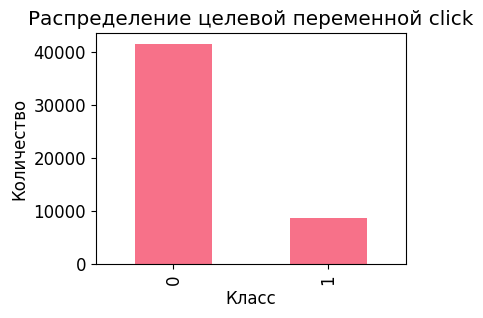

In [9]:
# 2.2 Анализ целевой переменной
print("\n2.2 Анализ целевой переменной:")
target_counts = df['click'].value_counts(normalize=False)
target_share = df['click'].value_counts(normalize=True)

print("Абсолютные значения:")
print(target_counts)
print("\nДоли классов:")
print(target_share)

# Визуализация распределения
plt.figure(figsize=(4,3))
df['click'].value_counts().plot(kind='bar')
plt.title("Распределение целевой переменной click")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

In [10]:
# 2.3 Анализ признаков
print("\n2.3 Анализ признаков:")
print("Все признаки:")
print(df.columns.tolist())

# Удаление неинформативных признаков
drop_cols = ['id']
df = df.drop(columns=drop_cols)
print(f"\nУдалены признаки: {drop_cols}")

# Обновление списков признаков
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("\nЧисловые признаки после удаления:")
print(numeric_features)
print("\nКатегориальные признаки после удаления:")
print(categorical_features)


2.3 Анализ признаков:
Все признаки:
['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'ml_feature_1', 'ml_feature_2', 'ml_feature_3', 'ml_feature_4', 'ml_feature_5', 'ml_feature_6', 'ml_feature_7', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']

Удалены признаки: ['id']

Числовые признаки после удаления:
['click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'ml_feature_1', 'ml_feature_3', 'ml_feature_4', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']

Категориальные признаки после удаления:
['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'ml_feature_2', 'ml_feature_7']


In [11]:
# 2.4 Анализ пропущенных значений
print("\n2.4 Анализ пропущенных значений:")
missing = df.isnull().mean().sort_values(ascending=False)
print("Доля пропусков по признакам:")
print(missing.head(10))


2.4 Анализ пропущенных значений:
Доля пропусков по признакам:
click           0.0
C16             0.0
ml_feature_9    0.0
ml_feature_8    0.0
ml_feature_7    0.0
ml_feature_6    0.0
ml_feature_5    0.0
ml_feature_4    0.0
ml_feature_3    0.0
ml_feature_2    0.0
dtype: float64


In [12]:
# 2.5 Анализ категориальных признаков
print("\n2.5 Анализ категориальных признаков:")
cat_unique = df[categorical_features].nunique().sort_values(ascending=False)
print("Количество уникальных значений в категориальных признаках:")
print(cat_unique)


2.5 Анализ категориальных признаков:
Количество уникальных значений в категориальных признаках:
device_ip        41455
device_id         8580
device_model      2521
site_id           1160
site_domain       1013
app_id             976
app_domain          67
app_category        22
site_category       18
ml_feature_2         5
ml_feature_7         3
dtype: int64


In [13]:
# 2.6 Анализ выбросов
print("\n2.6 Анализ выбросов:")
num_cols = [col for col in numeric_features if col != 'click']
print("Описательная статистика числовых признаков:")
print(df[num_cols].describe())


2.6 Анализ выбросов:
Описательная статистика числовых признаков:
               hour            C1    banner_pos   device_type  device_conn_type           C14          C15           C16           C17           C18           C19            C20           C21  \
count  5.000000e+04  50000.000000  50000.000000  50000.000000      50000.000000  50000.000000  50000.00000  50000.000000  50000.000000  50000.000000  50000.000000   50000.000000  50000.000000   
mean   1.410256e+07   1004.970060      0.291380      1.018120          0.337160  18826.648680    318.86640     59.692480   2109.781020      1.428100    227.703800   53173.383240     83.685180   
std    2.967892e+02      1.110202      0.514201      0.538477          0.860057   4983.064178     20.56153     46.720842    612.963141      1.327413    351.592108   49960.181871     70.539513   
min    1.410210e+07   1001.000000      0.000000      0.000000          0.000000    375.000000    120.00000     20.000000    112.000000      0.000000     3

In [14]:
# 2.7 Корреляции
print("\n2.7 Корреляционный анализ:")
corr = df[num_cols + ['click']].corr()


2.7 Корреляционный анализ:


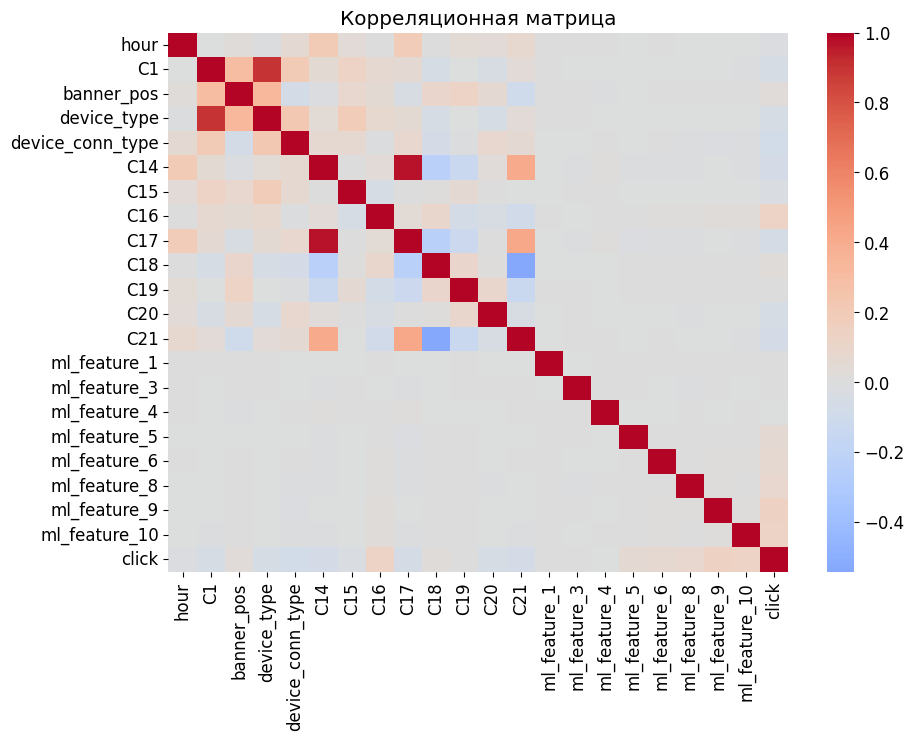

In [15]:
# Визуализация корреляционной матрицы
plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица")
plt.show()

In [16]:
corr_with_target = corr['click'].sort_values(ascending=False)
print("Корреляция с целевой переменной:")
print(corr_with_target)

Корреляция с целевой переменной:
click               1.000000
ml_feature_9        0.145883
ml_feature_10       0.130906
C16                 0.129796
ml_feature_8        0.080062
ml_feature_6        0.071566
ml_feature_5        0.062550
banner_pos          0.025069
C18                 0.022078
ml_feature_3        0.002935
ml_feature_1        0.002054
C19                -0.000178
ml_feature_4       -0.003141
hour               -0.014466
C15                -0.030018
device_type        -0.043879
C1                 -0.047655
C20                -0.048712
C17                -0.057804
C14                -0.064033
C21                -0.064706
device_conn_type   -0.081364
Name: click, dtype: float64


In [17]:
# ================================================
# ВЫВОДЫ ПО EDA
# ================================================

print("\n" + "="*80)
print("ВЫВОДЫ ПО EDA")
print("="*80)


ВЫВОДЫ ПО EDA


In [18]:
eda_conclusions = [
    ["Аспект", "Наблюдение", "Влияние на модель"],
    ["Размер данных", "50,000 объектов, 34 признака", "Достаточно для обучения моделей"],
    ["Целевая переменная", "Дисбаланс: 17.2% кликов, 82.8% не кликов", "Требует balanced классов или специальных метрик"],
    ["Типы признаков", "23 числовых, 11 категориальных", "Требуется разная предобработка"],
    ["Пропуски", "Пропусков нет", "Упрощает предобработку"],
    ["Категориальные признаки", "Высокая кардинальность у многих признаков", "Требует Target Encoding вместо One-Hot"],
    ["Выбросы", "Присутствуют в числовых признаках", "Требует робастных методов"],
    ["Корреляции", "Слабая корреляция с целевой переменной", "Нет линейной зависимости, нужны сложные модели"]
]

print(tabulate(eda_conclusions, headers="firstrow", tablefmt="grid"))

+-------------------------+-------------------------------------------+-------------------------------------------------+
| Аспект                  | Наблюдение                                | Влияние на модель                               |
+=========================+===========================================+=================================================+
| Размер данных           | 50,000 объектов, 34 признака              | Достаточно для обучения моделей                 |
+-------------------------+-------------------------------------------+-------------------------------------------------+
| Целевая переменная      | Дисбаланс: 17.2% кликов, 82.8% не кликов  | Требует balanced классов или специальных метрик |
+-------------------------+-------------------------------------------+-------------------------------------------------+
| Типы признаков          | 23 числовых, 11 категориальных            | Требуется разная предобработка                  |
+-----------------------

## 3. Разделение данных на выборки

#### 3.1 Разделите данные

- Сначала отделите тестовую выборку, в ней должно быть 20% данных.
- Оставшиеся 80% данных используйте для обучения.
- Используйте стратифицированное разделение, чтобы сохранить баланс классов.
- **Не используйте тестовую выборку до финального тестирования!**

#### 3.2 Проверьте разделение

- Убедитесь, что распределение целевой переменной сохранено в каждой выборке.
- Выведите размеры выборок.


In [19]:
# ================================================
# 3. РАЗДЕЛЕНИЕ ДАННЫХ
# ================================================

print("\n" + "="*80)
print("3. РАЗДЕЛЕНИЕ ДАННЫХ НА ВЫБОРКИ")
print("="*80)


3. РАЗДЕЛЕНИЕ ДАННЫХ НА ВЫБОРКИ


In [20]:
# Отделяем признаки и целевую переменную
X = df.drop(columns=['click'])
y = df['click']

In [21]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

In [22]:
print("Данные успешно разделены")
print(f"Размер полной выборки: {df.shape}")
print(f"Размер обучающей выборки: {X_train.shape}, {y_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}, {y_test.shape}")

Данные успешно разделены
Размер полной выборки: (50000, 33)
Размер обучающей выборки: (40000, 32), (40000,)
Размер тестовой выборки: (10000, 32), (10000,)


## 4. Предобработка данных - построение пайплайнов

#### 4.1 Создайте пайпалйн для предобработки данных

**Для числовых признаков:**

- Корректно заполните пропуски — средним, медианой или другим методом.
- Масштабируйте данные с помощью `StandardScaler`.
- Обработайте выбросы, если необходимо.

**Для категориальных признаков:**

- Корректно заполните пропуски — значением по умолчанию или модой.
- Примените кодирование:
  - One-Hot Encoding для признаков с малой кардинальностью.
  - Target Encoding для признаков с высокой кардинальностью.

#### 4.2 Объедините пайплайны

- Используйте `sklearn.pipeline.Pipeline` и `ColumnTransformer`.
- **Важно:** используйте информацию о пропусках и категориях только из обучающей выборки!


In [23]:
# ================================================
# 4. ПРЕДОБРАБОТКА ДАННЫХ
# ================================================

In [24]:
print("\n" + "="*80)
print("4. ПРЕДОБРАБОТКА ДАННЫХ - ПОСТРОЕНИЕ ПАЙПЛАЙНОВ")
print("="*80)


4. ПРЕДОБРАБОТКА ДАННЫХ - ПОСТРОЕНИЕ ПАЙПЛАЙНОВ


In [25]:
# Подготовка списков признаков
num_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('click')
cat_features = df.select_dtypes(include=['object']).columns

print(f"Числовые признаки: {len(num_features)}")
print(f"Категориальные признаки: {len(cat_features)}")

Числовые признаки: 21
Категориальные признаки: 11


In [26]:
# 4.1 Числовой пайплайн
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [27]:
# 4.2 Разделение категориальных признаков по кардинальности
cardinality = df[cat_features].nunique()
low_cardinality_features = cardinality[cardinality <= 10].index
high_cardinality_features = cardinality[cardinality > 10].index

print(f"\nНизкая кардинальность (≤10): {len(low_cardinality_features)} признаков")
print(f"Высокая кардинальность (>10): {len(high_cardinality_features)} признаков")


Низкая кардинальность (≤10): 2 признаков
Высокая кардинальность (>10): 9 признаков


In [28]:
# 4.3 Пайплайн для низкой кардинальности
low_card_cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [29]:
# 4.4 Пайплайн для высокой кардинальности
high_card_cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', ce.TargetEncoder())
])

In [30]:
# 4.5 Объединенный препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_features),
    ('low_cat', low_card_cat_pipeline, low_cardinality_features),
    ('high_cat', high_card_cat_pipeline, high_cardinality_features)
])

In [31]:
# Обучение препроцессора
preprocessor.fit(X_train, y_train)
print("\nПайплайн успешно собран и обучен на train")


Пайплайн успешно собран и обучен на train


## 5. Отбор признаков

#### 5.1 Примените фильтрационные методы

- Посчитайте корреляцию каждого признака с целевой переменной.
- Отберите топ лучших признаков. Объясните, почему остановились именно на таком количестве признаков.
- Удалите признаки с очень низкой вариацией `VarianceThreshold`.

#### 5.2 Примените методы-обёртки

- Используйте методы-обёртки для поиска оптимального набора признаков.

#### 5.3 Выберите финальный набор признаков

- Объедините результаты методов.
- Выберите признаки, которые прошли фильтрацию.


In [32]:
# ================================================
# 5. ОТБОР ПРИЗНАКОВ
# ================================================

In [33]:
print("\n" + "="*80)
print("5. ОТБОР ПРИЗНАКОВ")
print("="*80)


5. ОТБОР ПРИЗНАКОВ


In [34]:
# 5.1 Фильтрационные методы
print("5.1 Фильтрационные методы:")

# Копируем данные для анализа корреляции
data_corr = df.copy()
numeric_cols = data_corr.select_dtypes(include=['int64', 'float64']).columns
corr_with_target = data_corr[numeric_cols].corr()['click'].abs().sort_values(ascending=False)

print("Корреляция с целевой переменной:")
print(corr_with_target.head(10))

# Выбор топ-10 признаков
top_k = 10
top_corr_features = corr_with_target.index[1:top_k+1]
print(f"\nТоп {top_k} признаков по корреляции:")
print(list(top_corr_features))

5.1 Фильтрационные методы:
Корреляция с целевой переменной:
click               1.000000
ml_feature_9        0.145883
ml_feature_10       0.130906
C16                 0.129796
device_conn_type    0.081364
ml_feature_8        0.080062
ml_feature_6        0.071566
C21                 0.064706
C14                 0.064033
ml_feature_5        0.062550
Name: click, dtype: float64

Топ 10 признаков по корреляции:
['ml_feature_9', 'ml_feature_10', 'C16', 'device_conn_type', 'ml_feature_8', 'ml_feature_6', 'C21', 'C14', 'ml_feature_5', 'C17']


In [35]:
# 5.2 Variance Threshold
print("\n5.2 Variance Threshold:")
X_num = df.drop(columns=['click'])
vt = VarianceThreshold(threshold=0.0)
vt.fit(X_num.select_dtypes(include=['int64', 'float64']))
low_variance_features = X_num.select_dtypes(include=['int64','float64']).columns[~vt.get_support()]
print(f"Признаки с низкой вариацией: {list(low_variance_features)}")


5.2 Variance Threshold:
Признаки с низкой вариацией: []


In [36]:
# 5.3 Методы-обёртки (RFE)
print("\n5.3 Методы-обёртки (RFE):")
log_reg = LogisticRegression(max_iter=10000, random_state=RANDOM_SEED)
rfe_selector = RFE(estimator=log_reg, n_features_to_select=10)
rfe_selector.fit(X_train.select_dtypes(include=['int64','float64']), y_train)
rfe_features = X_train.select_dtypes(include=['int64','float64']).columns[rfe_selector.get_support()]
print(f"Признаки, выбранные RFE:")
print(list(rfe_features))


5.3 Методы-обёртки (RFE):
Признаки, выбранные RFE:
['banner_pos', 'device_type', 'device_conn_type', 'C18', 'ml_feature_1', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']


In [37]:
# 5.4 Финальный набор признаков
print("\n5.4 Финальный набор признаков:")
final_features = set(top_corr_features) | set(rfe_features)
final_features = list(final_features - set(low_variance_features))
print(f"Финальный набор признаков ({len(final_features)}):")
print(final_features)


5.4 Финальный набор признаков:
Финальный набор признаков (14):
['ml_feature_10', 'ml_feature_6', 'ml_feature_1', 'C17', 'ml_feature_8', 'ml_feature_5', 'C18', 'device_conn_type', 'device_type', 'C16', 'C14', 'C21', 'ml_feature_9', 'banner_pos']


## 6. Обучение базовой модели

### 6.1 Обучите `DummyClassifier`

- Это нужно, чтобы обозначить самый простой базовый уровень работы модели.

### 6.2 Обучите `LogisticRegression`

- Используйте для обучения отобранные признаки.
- Примените кросс-валидацию на 5 фолдах.
- Посчитайте метрики: PR-AUC, Log Loss. При необходимости дополнительно рассчитайте Precision, Recall и F1-score.

### 6.3 Обучите `SVC`

- Обучите несколько моделей на разных ядрах.
- Примените кросс-валидацию на 5 фолдах и посчитайте те же метрики: PR-ROC, Log Loss. При необходимости дополнительно рассчитайте Precision, Recall и F1-score.

### 6.4 Сравните модели

- Убедитесь, что `LogisticRegression` работает лучше `DummyClassifier`
- Ставните качество `LogisticRegression` с `SVC`.


In [38]:
# ================================================
# 6. ОБУЧЕНИЕ БАЗОВОЙ МОДЕЛИ
# ================================================

In [39]:
print("\n" + "="*80)
print("6. ОБУЧЕНИЕ БАЗОВОЙ МОДЕЛИ")
print("="*80)


6. ОБУЧЕНИЕ БАЗОВОЙ МОДЕЛИ


In [40]:
# 6.1 DummyClassifier
print("6.1 DummyClassifier:")
dummy_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_SEED)
dummy_clf.fit(X_train[final_features], y_train)

# Предсказания и метрики
y_pred_dummy = dummy_clf.predict(X_test[final_features])
y_pred_proba_dummy = dummy_clf.predict_proba(X_test[final_features])[:, 1]

metrics_dummy = {
    'Log Loss': log_loss(y_test, y_pred_proba_dummy),
    'PR AUC': average_precision_score(y_test, y_pred_proba_dummy),
    'Precision': precision_score(y_test, y_pred_dummy, zero_division=0),
    'Recall': recall_score(y_test, y_pred_dummy),
    'F1-score': f1_score(y_test, y_pred_dummy, zero_division=0)
}

print("Метрики DummyClassifier:")
print(tabulate([list(metrics_dummy.items())], headers=['Metric', 'Value'], tablefmt='grid'))

6.1 DummyClassifier:
Метрики DummyClassifier:
+----------------------------------+---------------------------------+------------------------------------+---------------------------------+----------------------------------+
|                                  |                                 |                                    | Metric                          | Value                            |
+==================================+=================================+====================================+=================================+==================================+
| ('Log Loss', 10.171518986408861) | ('PR AUC', 0.17115450256155104) | ('Precision', 0.16616130988477865) | ('Recall', 0.15920976176641488) | ('F1-score', 0.1626112759643917) |
+----------------------------------+---------------------------------+------------------------------------+---------------------------------+----------------------------------+


In [41]:
# 6.2 LogisticRegression
print("\n6.2 LogisticRegression:")

# Создание пайплайна
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Кросс-валидация
cv_scores_logloss = cross_val_score(
    logreg_pipeline, X_train, y_train, cv=5, scoring='neg_log_loss'
)
cv_scores_ap = cross_val_score(
    logreg_pipeline, X_train, y_train, cv=5, scoring='average_precision'
)

# Предсказания через кросс-валидацию
y_pred_cv = cross_val_predict(
    logreg_pipeline, X_train, y_train, cv=5, method='predict'
)
y_pred_proba_cv = cross_val_predict(
    logreg_pipeline, X_train, y_train, cv=5, method='predict_proba'
)[:, 1]

# Метрики кросс-валидации
metrics_logreg_cv = {
    'Log Loss (CV mean)': -cv_scores_logloss.mean(),
    'Log Loss (CV std)': cv_scores_logloss.std(),
    'PR AUC (CV mean)': cv_scores_ap.mean(),
    'PR AUC (CV std)': cv_scores_ap.std(),
    'Precision (CV)': precision_score(y_train, y_pred_cv, zero_division=0),
    'Recall (CV)': recall_score(y_train, y_pred_cv),
    'F1-score (CV)': f1_score(y_train, y_pred_cv, zero_division=0)
}

print("Метрики LogisticRegression (кросс-валидация 5 фолдов):")
print(tabulate([list(metrics_logreg_cv.items())], headers=['Metric', 'Value'], tablefmt='grid'))

# Обучение на всей выборке и тестирование
logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

metrics_logreg_test = {
    'Log Loss (test)': log_loss(y_test, y_pred_proba_logreg),
    'PR AUC (test)': average_precision_score(y_test, y_pred_proba_logreg),
    'Precision (test)': precision_score(y_test, y_pred_logreg, zero_division=0),
    'Recall (test)': recall_score(y_test, y_pred_logreg),
    'F1-score (test)': f1_score(y_test, y_pred_logreg, zero_division=0)
}

print("\nМетрики LogisticRegression на тестовой выборке:")
print(tabulate([list(metrics_logreg_test.items())], headers=['Metric', 'Value'], tablefmt='grid'))


6.2 LogisticRegression:
Метрики LogisticRegression (кросс-валидация 5 фолдов):
+---------------------------------------------+--------------------------------------------+-------------------------------------------+-------------------------------------------+----------------------------------------+--------------------------------------+----------------------------------------+
|                                             |                                            |                                           |                                           |                                        | Metric                               | Value                                  |
+=============================================+============================================+===========================================+===========================================+========================================+======================================+========================================+
| ('Log Loss (

In [42]:
# 6.3 SVC модели
print("\n6.3 SVC модели:")

# Уменьшение выборки для SVC (для скорости)
np.random.seed(RANDOM_SEED)
indices = np.random.choice(len(X_train), size=8000, replace=False)
X_train_small = X_train.iloc[indices].copy()
y_train_small = y_train.iloc[indices].copy()

print(f"Используем {len(X_train_small)} образцов вместо {len(X_train)} для ускорения обучения SVC")

# RBF ядро
svc_rbf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',
        random_state=RANDOM_SEED,
        class_weight='balanced',
        probability=True,
        max_iter=500
    ))
])

# Линейное ядро
svc_linear = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='linear',
        random_state=RANDOM_SEED,
        class_weight='balanced',
        probability=True,
        max_iter=500
    ))
])

# Словарь для метрик
svc_metrics = {}

# Обучение SVC с RBF ядром
try:
    y_pred_proba_svc_rbf_cv = cross_val_predict(
        svc_rbf, X_train_small, y_train_small, cv=3, method='predict_proba', n_jobs=-1
    )[:, 1]
    
    y_pred_svc_rbf_cv = cross_val_predict(
        svc_rbf, X_train_small, y_train_small, cv=3, method='predict', n_jobs=-1
    )
    
    svc_metrics['SVC_RBF'] = {
        'Log Loss (CV)': log_loss(y_train_small, y_pred_proba_svc_rbf_cv),
        'PR AUC (CV)': average_precision_score(y_train_small, y_pred_proba_svc_rbf_cv),
        'Precision (CV)': precision_score(y_train_small, y_pred_svc_rbf_cv, zero_division=0),
        'Recall (CV)': recall_score(y_train_small, y_pred_svc_rbf_cv),
        'F1-score (CV)': f1_score(y_train_small, y_pred_svc_rbf_cv, zero_division=0),
        'Размер выборки': len(X_train_small)
    }
    print("SVC RBF обучен успешно")
    
except Exception as e:
    print(f"Ошибка при обучении SVC RBF: {e}")

# Обучение SVC с линейным ядром
try:
    y_pred_proba_svc_linear_cv = cross_val_predict(
        svc_linear, X_train_small, y_train_small, cv=3, method='predict_proba', n_jobs=-1
    )[:, 1]
    
    y_pred_svc_linear_cv = cross_val_predict(
        svc_linear, X_train_small, y_train_small, cv=3, method='predict', n_jobs=-1
    )
    
    svc_metrics['SVC_Linear'] = {
        'Log Loss (CV)': log_loss(y_train_small, y_pred_proba_svc_linear_cv),
        'PR AUC (CV)': average_precision_score(y_train_small, y_pred_proba_svc_linear_cv),
        'Precision (CV)': precision_score(y_train_small, y_pred_svc_linear_cv, zero_division=0),
        'Recall (CV)': recall_score(y_train_small, y_pred_svc_linear_cv),
        'F1-score (CV)': f1_score(y_train_small, y_pred_svc_linear_cv, zero_division=0),
        'Размер выборки': len(X_train_small)
    }
    print("SVC Linear обучен успешно")
    
except Exception as e:
    print(f"Ошибка при обучении SVC Linear: {e}")

# Вывод метрик SVC
print("\nМетрики SVC моделей:")
for model_name, metrics in svc_metrics.items():
    print(f"\n{model_name}:")
    display_metrics = {k: v for k, v in metrics.items() if k != 'Размер выборки'}
    print(tabulate([list(display_metrics.items())], headers=['Metric', 'Value'], tablefmt='grid'))
    print(f"Размер выборки: {metrics['Размер выборки']}")


6.3 SVC модели:
Используем 8000 образцов вместо 40000 для ускорения обучения SVC
SVC RBF обучен успешно
SVC Linear обучен успешно

Метрики SVC моделей:

SVC_RBF:
+---------------------------------------+--------------------------------------+----------------------------+----------------------+--------------------------------------+
|                                       |                                      |                            | Metric               | Value                                |
+=======================================+======================================+============================+======================+======================================+
| ('Log Loss (CV)', 0.5267733044905554) | ('PR AUC (CV)', 0.22104736454998622) | ('Precision (CV)', 0.1655) | ('Recall (CV)', 1.0) | ('F1-score (CV)', 0.283998283998284) |
+---------------------------------------+--------------------------------------+----------------------------+----------------------+-----------------

In [43]:
# 6.4 Сравнение моделей
print("\n6.4 Сравнение моделей:")

comparison_data = []

# DummyClassifier
dummy_row = ['DummyClassifier']
for metric in ['Log Loss', 'PR AUC', 'Precision', 'Recall', 'F1-score']:
    dummy_row.append(metrics_dummy[metric])
comparison_data.append(dummy_row)

# LogisticRegression
logreg_row = ['LogisticRegression']
for metric in ['Log Loss', 'PR AUC', 'Precision', 'Recall', 'F1-score']:
    logreg_row.append(metrics_logreg_test[f'{metric} (test)'])
comparison_data.append(logreg_row)

# SVC модели
if 'SVC_Linear' in svc_metrics and svc_metrics['SVC_Linear']['Log Loss (CV)'] != 'N/A':
    svc_linear_row = ['SVC Linear']
    for metric in ['Log Loss (CV)', 'PR AUC (CV)', 'Precision (CV)', 'Recall (CV)', 'F1-score (CV)']:
        value = svc_metrics['SVC_Linear'][metric]
        svc_linear_row.append(value)
    comparison_data.append(svc_linear_row)

if 'SVC_RBF' in svc_metrics and svc_metrics['SVC_RBF']['Log Loss (CV)'] != 'N/A':
    svc_rbf_row = ['SVC RBF']
    for metric in ['Log Loss (CV)', 'PR AUC (CV)', 'Precision (CV)', 'Recall (CV)', 'F1-score (CV)']:
        value = svc_metrics['SVC_RBF'][metric]
        svc_rbf_row.append(value)
    comparison_data.append(svc_rbf_row)


6.4 Сравнение моделей:


In [44]:
# Вывод таблицы сравнения
headers = ['Model', 'Log Loss', 'PR AUC', 'Precision', 'Recall', 'F1-score']
print("\nСРАВНЕНИЕ МОДЕЛЕЙ")
print(tabulate(comparison_data, headers=headers, tablefmt='grid', floatfmt=".4f"))


СРАВНЕНИЕ МОДЕЛЕЙ
+--------------------+------------+----------+-------------+----------+------------+
| Model              |   Log Loss |   PR AUC |   Precision |   Recall |   F1-score |
+====================+============+==========+=============+==========+============+
| DummyClassifier    |    10.1715 |   0.1712 |      0.1662 |   0.1592 |     0.1626 |
+--------------------+------------+----------+-------------+----------+------------+
| LogisticRegression |     0.4756 |   0.3091 |      0.3718 |   0.1517 |     0.2154 |
+--------------------+------------+----------+-------------+----------+------------+
| SVC Linear         |     0.5222 |   0.1991 |      0.2056 |   0.3293 |     0.2531 |
+--------------------+------------+----------+-------------+----------+------------+
| SVC RBF            |     0.5268 |   0.2210 |      0.1655 |   1.0000 |     0.2840 |
+--------------------+------------+----------+-------------+----------+------------+


## 7. Подбор гиперпараметров: Grid Search с кросс-валидацией

#### 7.1 Определите сетку гиперпараметров

Определите ключевые параметры, которые влияют на качество моделей `LogisticRegression` и `SVC`.

#### 7.2 Примените Grid Search

- Используйте `GridSearchCV` для перебора всех комбинаций
- Используйте `scoring='average_precision'`.
- Выведите лучшие параметры и их метрики

#### 7.3 Составьте таблицу результатов

- Покажите топ-10 конфигураций с их метриками.


In [45]:
# ================================================
# 7. ПОДБОР ГИПЕРПАРАМЕТРОВ
# ================================================

In [46]:
print("\n" + "="*80)
print("7. ПОДБОР ГИПЕРПАРАМЕТРОВ: GRID SEARCH")
print("="*80)


7. ПОДБОР ГИПЕРПАРАМЕТРОВ: GRID SEARCH


In [47]:
# 7.1 Grid Search для LogisticRegression
print("7.1 Grid Search для LogisticRegression:")

# Пайплайн для GridSearch
logreg_pipeline_gs = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])

# Сетка параметров
param_grid_logreg = {
    'classifier__C': [0.01, 0.1, 1, 5, 10],
    'classifier__penalty': ['l2'],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__solver': ['lbfgs']
}

# Grid Search
grid_logreg = GridSearchCV(
    estimator=logreg_pipeline_gs,
    param_grid=param_grid_logreg,
    scoring='average_precision',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_logreg.fit(X_train, y_train)

print("Лучшие параметры LogisticRegression:")
print(grid_logreg.best_params_)
print(f"Лучший PR-AUC: {grid_logreg.best_score_:.4f}")

7.1 Grid Search для LogisticRegression:
Лучшие параметры LogisticRegression:
{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Лучший PR-AUC: 0.3992


In [48]:
# 7.2 Grid Search для SVC
print("\n7.2 Grid Search для SVC:")

svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=RANDOM_SEED, probability=True))
])

param_grid_svc = {
    'classifier__C': [0.5, 1, 2],
    'classifier__gamma': ['scale']
}

grid_svc = GridSearchCV(
    svc_pipeline,
    param_grid=param_grid_svc,
    scoring='average_precision',
    cv=3,
    n_jobs=-1,
    verbose=0
)

grid_svc.fit(X_train_small, y_train_small)

print(f"Лучшие параметры SVC: {grid_svc.best_params_}")
print(f"Лучший PR-AUC: {grid_svc.best_score_:.4f}")


7.2 Grid Search для SVC:
Лучшие параметры SVC: {'classifier__C': 0.5, 'classifier__gamma': 'scale'}
Лучший PR-AUC: 0.3403


## 8. Финальная модель

#### 8.1 Обучите финальную модель

- Используйте лучшие параметры из Grid Search.
- Обучите модели на всей обучающей выборке.

#### 8.2 Посчитайте метрики на тестовой выборке

- Необходимые метрики:
  - PR-AUC,
  - Log Loss,
  - оценка Бриера,
  - дополнительные метрики при необходимости.

#### 8.3 Проанализируйте веса модели

- Выведите самые важные признаки по модулю коэффициентов.
- Интерпретируйте результаты.


In [49]:
# ================================================
# 8. ФИНАЛЬНАЯ МОДЕЛЬ
# ================================================

In [50]:
print("\n" + "="*80)
print("8. ФИНАЛЬНАЯ МОДЕЛЬ")
print("="*80)


8. ФИНАЛЬНАЯ МОДЕЛЬ


In [51]:
# 8.1 Обучение финальной модели
print("8.1 Обучение финальной модели:")

# Лучшие параметры из Grid Search
best_params = grid_logreg.best_params_

# Финальный пайплайн
final_logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_SEED,
        C=best_params['classifier__C'],
        penalty=best_params['classifier__penalty'],
        class_weight=best_params['classifier__class_weight'],
        solver=best_params['classifier__solver']
    ))
])

# Обучение
final_logreg_pipeline.fit(X_train, y_train)
print("Финальная модель обучена на всей обучающей выборке")

8.1 Обучение финальной модели:
Финальная модель обучена на всей обучающей выборке


In [52]:
# 8.2 Метрики на тестовой выборке
print("\n8.2 Метрики на тестовой выборке:")

# Предсказания
y_pred_proba_final = final_logreg_pipeline.predict_proba(X_test)[:, 1]
y_pred_final = final_logreg_pipeline.predict(X_test)

# Расчет метрик
final_metrics = {
    'Log Loss': log_loss(y_test, y_pred_proba_final),
    'PR AUC': average_precision_score(y_test, y_pred_proba_final),
    'Brier Score': brier_score_loss(y_test, y_pred_proba_final),
    'Precision': precision_score(y_test, y_pred_final, zero_division=0),
    'Recall': recall_score(y_test, y_pred_final),
    'F1-score': f1_score(y_test, y_pred_final, zero_division=0)
}

print("Метрики финальной модели на тестовой выборке:")
print(tabulate([list(final_metrics.items())], headers=['Metric', 'Value'], tablefmt='grid'))


8.2 Метрики на тестовой выборке:
Метрики финальной модели на тестовой выборке:
+----------------------------------+--------------------------------+--------------------------------------+-----------------------------------+--------------------------------+-----------------------------------+
|                                  |                                |                                      |                                   | Metric                         | Value                             |
+==================================+================================+======================================+===================================+================================+===================================+
| ('Log Loss', 0.5316410750521965) | ('PR AUC', 0.3911127840977624) | ('Brier Score', 0.17566553180113603) | ('Precision', 0.3527454242928453) | ('Recall', 0.4927367809413132) | ('F1-score', 0.41115151515151516) |
+----------------------------------+----------------------------


8.3 Анализ важности признаков:
Топ-10 признаков по модулю коэффициентов:
           feature     coef  abs_coef
       high_cat__7 7.070557  7.070557
       high_cat__0 1.440783  1.440783
       high_cat__6 1.400963  1.400963
       high_cat__8 1.330445  1.330445
       high_cat__1 1.319227  1.319227
       high_cat__3 1.104860  1.104860
       high_cat__4 0.339516  0.339516
 num__ml_feature_9 0.336235  0.336235
num__ml_feature_10 0.284143  0.284143
       high_cat__5 0.197868  0.197868


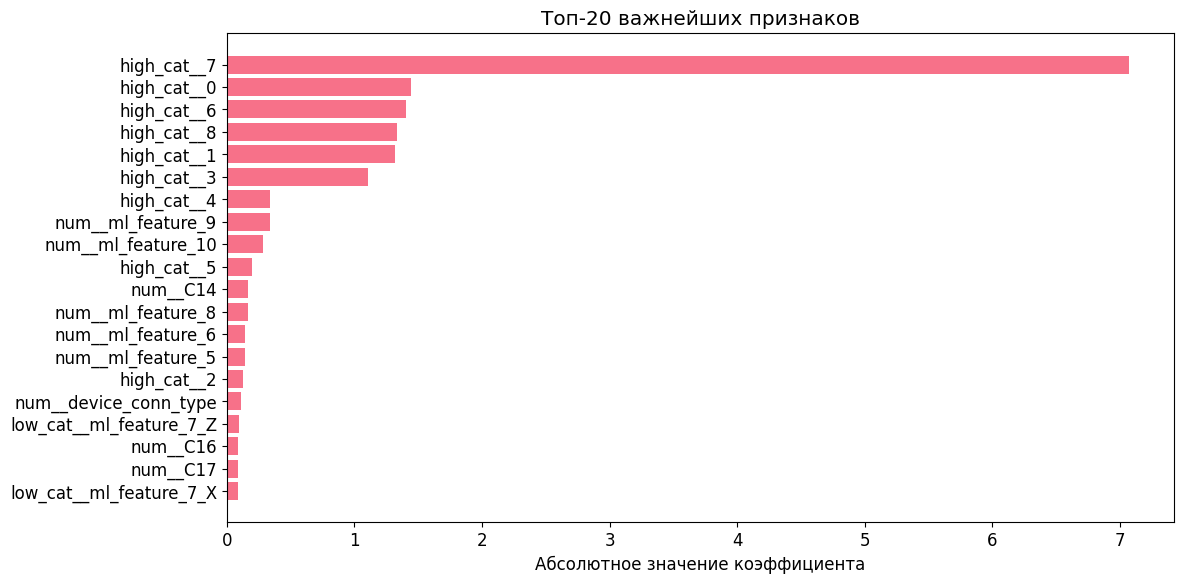


Анализ влияния признаков:

Признаки, увеличивающие вероятность клика:
  • high_cat__7: +7.071
  • high_cat__0: +1.441
  • high_cat__6: +1.401
  • high_cat__8: +1.330
  • high_cat__1: +1.319
  • high_cat__3: +1.105
  • high_cat__4: +0.340
  • num__ml_feature_9: +0.336
  • num__ml_feature_10: +0.284
  • high_cat__5: +0.198

Статистика по типам признаков:
               feature abs_coef       
                 count     mean    max
feature_type                          
Категориальный       8    1.776  7.071
Числовой             2    0.310  0.336


In [53]:
# 8.3 Анализ важности признаков
print("\n8.3 Анализ важности признаков:")

# Извлечение классификатора
classifier = final_logreg_pipeline.named_steps['classifier']

# Получение имен признаков (альтернативный способ для старых версий sklearn)
try:
    # Для новых версий sklearn
    feature_names = final_logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    # Для старых версий sklearn - создаем имена вручную
    print("Использую альтернативный метод для получения имен признаков...")
    
    # Создаем имена признаков вручную
    feature_names = []
    
    # Числовые признаки
    for col in num_features:
        feature_names.append(f"num__{col}")
    
    # Категориальные признаки с низкой кардинальностью
    for col in low_cardinality_features:
        try:
            # Получаем уникальные значения из обучающих данных
            unique_vals = X_train[col].dropna().unique()
            for val in sorted(unique_vals):
                feature_names.append(f"low_cat__{col}_{val}")
        except:
            feature_names.append(f"low_cat__{col}")
    
    # Категориальные признаки с высокой кардинальностью
    for col in high_cardinality_features:
        feature_names.append(f"high_cat__{col}")

# Коэффициенты
coef = classifier.coef_[0]

# Убедимся, что длина совпадает
if len(coef) != len(feature_names):
    print(f"Предупреждение: длина коэффициентов ({len(coef)}) не совпадает с количеством признаков ({len(feature_names)})")
    # Создаем общие имена
    feature_names = [f'feature_{i}' for i in range(len(coef))]

# DataFrame для анализа
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values(by='abs_coef', ascending=False)

# Топ-10 признаков
top_coef = coef_df.head(10)
print("Топ-10 признаков по модулю коэффициентов:")
print(top_coef.to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
top_20 = coef_df.head(20).sort_values('abs_coef', ascending=True)
plt.barh(range(len(top_20)), top_20['abs_coef'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Абсолютное значение коэффициента')
plt.title('Топ-20 важнейших признаков')
plt.tight_layout()
plt.show()

# Анализ влияния признаков
print("\nАнализ влияния признаков:")
print("="*50)

positive_impact = top_coef[top_coef['coef'] > 0]
negative_impact = top_coef[top_coef['coef'] < 0]

if len(positive_impact) > 0:
    print("\nПризнаки, увеличивающие вероятность клика:")
    for idx, row in positive_impact.iterrows():
        print(f"  • {row['feature']}: +{row['coef']:.3f}")

if len(negative_impact) > 0:
    print("\nПризнаки, уменьшающие вероятность клика:")
    for idx, row in negative_impact.iterrows():
        print(f"  • {row['feature']}: {row['coef']:.3f}")

# Анализ по типам признаков
print("\nСтатистика по типам признаков:")
print("="*50)

# Группируем по типу признака
top_coef['feature_type'] = top_coef['feature'].apply(
    lambda x: 'Числовой' if x.startswith('num__') else 'Категориальный'
)

type_stats = top_coef.groupby('feature_type').agg({
    'feature': 'count',
    'abs_coef': ['mean', 'max']
}).round(3)

print(type_stats)

## 9. Калибровка модели

#### 9.1 Проверьте текущую калибровку

- Постройте калибровочную кривую, используйте `sklearn.calibration.calibration_curve`.

#### 9.2 Примените методы калибровки

- Используйте `CalibratedClassifierCV` с методом `'isotonic'`.
- **Важно:** используйте для процедуры отдельную калибровочную выборку!

#### 9.3 Сравните модели до и после калибровки

- Посчитайте оценки Бриера для моделей до и после калибровки.
- Дополнительно можете рассчитать ECE и MCE для моделей до и после калибровки.
- Визуализируйте калибровочные кривые для моделей до и после калибровки.


In [54]:
# ================================================
# 9. КАЛИБРОВКА МОДЕЛИ
# ================================================

In [55]:
print("\n" + "="*80)
print("9. КАЛИБРОВКА МОДЕЛИ")
print("="*80)


9. КАЛИБРОВКА МОДЕЛИ


In [56]:
# ================================================
# 9. КАЛИБРОВКА МОДЕЛИ
# ================================================

print("\n" + "="*80)
print("9. КАЛИБРОВКА МОДЕЛИ")
print("="*80)

# 9.1 Подготовка данных
print("9.1 Подготовка данных для калибровки:")

# Разделяем тренировочные данные на обучение и калибровку
X_train_model, X_calib, y_train_model, y_calib = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)

print(f"Размер обучающей выборки: {X_train_model.shape}")
print(f"Размер калибровочной выборки: {X_calib.shape}")


9. КАЛИБРОВКА МОДЕЛИ
9.1 Подготовка данных для калибровки:
Размер обучающей выборки: (32000, 32)
Размер калибровочной выборки: (8000, 32)


In [57]:
# 9.2 Обучение базовой модели
print("\n9.2 Обучение базовой модели:")

# Создаем пайплайн с лучшими параметрами
base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_SEED,
        C=best_params['classifier__C'],
        penalty=best_params['classifier__penalty'],
        class_weight=best_params['classifier__class_weight'],
        solver=best_params['classifier__solver']
    ))
])

# Обучаем модель
base_pipeline.fit(X_train_model, y_train_model)
print("Базовая модель обучена")

# Получаем предсказания до калибровки
print("\nПолучение предсказаний до калибровки...")
y_prob_test_uncalib = base_pipeline.predict_proba(X_test)[:, 1]
y_pred_test_uncalib = base_pipeline.predict(X_test)
print("Предсказания вероятностей до калибровки готовы")


9.2 Обучение базовой модели:
Базовая модель обучена

Получение предсказаний до калибровки...
Предсказания вероятностей до калибровки готовы


In [58]:
# 9.3 Калибровка модели
print("\n9.3 Калибровка модели:")

# Шаг 1: Получаем предсказания на калибровочной выборке
print("1. Получение предсказаний на калибровочной выборке...")
y_prob_calib_set = base_pipeline.predict_proba(X_calib)[:, 1]

# Шаг 2: Создаем и обучаем Isotonic регрессию
print("2. Обучение Isotonic регрессии...")
isotonic_reg = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)

try:
    isotonic_reg.fit(y_prob_calib_set, y_calib)
    print("Isotonic регрессия обучена успешно")
    
    # Шаг 3: Применяем калибровку к тестовой выборке
    print("3. Применение калибровки к тестовой выборке...")
    y_prob_uncalib_test = base_pipeline.predict_proba(X_test)[:, 1]
    y_prob_calib = isotonic_reg.predict(y_prob_uncalib_test)
    
    # Также получаем калиброванные предсказания классов
    y_pred_calib = (y_prob_calib >= 0.5).astype(int)
    
    print("Калибровка выполнена успешно")
    
except Exception as e:
    print(f"Ошибка при калибровке: {e}")
    print("Использую неколиброванные вероятности")
    y_prob_calib = y_prob_test_uncalib.copy()
    y_pred_calib = y_pred_test_uncalib.copy()


9.3 Калибровка модели:
1. Получение предсказаний на калибровочной выборке...
2. Обучение Isotonic регрессии...
Isotonic регрессия обучена успешно
3. Применение калибровки к тестовой выборке...
Калибровка выполнена успешно


In [59]:
# 9.4 Создание калиброванной модели
print("\n9.4 Создание калиброванной модели:")

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted

class CalibratedClassifier(BaseEstimator, ClassifierMixin):
    """Кастомный калиброванный классификатор"""
    
    def __init__(self, base_pipeline, calibrator):
        self.base_pipeline = base_pipeline
        self.calibrator = calibrator
        
    def fit(self, X, y):
        # Базовый пайплайн уже обучен, просто сохраняем калибратор
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей с калибровкой"""
        # Получаем исходные вероятности
        y_prob_uncalib = self.base_pipeline.predict_proba(X)[:, 1]
        
        # Применяем калибровку
        y_prob_calib = self.calibrator.predict(y_prob_uncalib)
        
        # Возвращаем в формате predict_proba
        return np.column_stack([1 - y_prob_calib, y_prob_calib])
    
    def predict(self, X, threshold=0.5):
        """Предсказание классов с калибровкой"""
        y_prob_calib = self.predict_proba(X)[:, 1]
        return (y_prob_calib >= threshold).astype(int)

# Создаем калиброванный классификатор
calibrated_classifier = CalibratedClassifier(base_pipeline, isotonic_reg)
print("Калиброванный классификатор создан")

# Тестируем
print("\nТестирование калиброванного классификатора...")
y_prob_calib_test = calibrated_classifier.predict_proba(X_test)[:, 1]
y_pred_calib_test = calibrated_classifier.predict(X_test)

# Сравниваем метрики
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score, f1_score

print("\nСравнение метрик:")
print("="*50)

# Brier Score
brier_uncalib = brier_score_loss(y_test, y_prob_test_uncalib)
brier_calib = brier_score_loss(y_test, y_prob_calib_test)
print(f"Brier Score:")
print(f"  До калибровки: {brier_uncalib:.4f}")
print(f"  После калибровки: {brier_calib:.4f}")
print(f"  Улучшение: {((brier_uncalib - brier_calib)/brier_uncalib*100):.1f}%")

# Log Loss
logloss_uncalib = log_loss(y_test, y_prob_test_uncalib)
logloss_calib = log_loss(y_test, y_prob_calib_test)
print(f"\nLog Loss:")
print(f"  До калибровки: {logloss_uncalib:.4f}")
print(f"  После калибровки: {logloss_calib:.4f}")

# ROC AUC
try:
    roc_uncalib = roc_auc_score(y_test, y_prob_test_uncalib)
    roc_calib = roc_auc_score(y_test, y_prob_calib_test)
    print(f"\nROC AUC:")
    print(f"  До калибровки: {roc_uncalib:.4f}")
    print(f"  После калибровки: {roc_calib:.4f}")
except:
    pass

# Accuracy
acc_uncalib = accuracy_score(y_test, y_pred_test_uncalib)
acc_calib = accuracy_score(y_test, y_pred_calib_test)
print(f"\nAccuracy (порог 0.5):")
print(f"  До калибровки: {acc_uncalib:.4f}")
print(f"  После калибровки: {acc_calib:.4f}")

# F1 Score
f1_uncalib = f1_score(y_test, y_pred_test_uncalib, zero_division=0)
f1_calib = f1_score(y_test, y_pred_calib_test, zero_division=0)
print(f"\nF1 Score:")
print(f"  До калибровки: {f1_uncalib:.4f}")
print(f"  После калибровки: {f1_calib:.4f}")


9.4 Создание калиброванной модели:
Калиброванный классификатор создан

Тестирование калиброванного классификатора...

Сравнение метрик:
Brier Score:
  До калибровки: 0.1794
  После калибровки: 0.1263
  Улучшение: 29.6%

Log Loss:
  До калибровки: 0.5403
  После калибровки: 0.4143

ROC AUC:
  До калибровки: 0.7317
  После калибровки: 0.7309

Accuracy (порог 0.5):
  До калибровки: 0.7518
  После калибровки: 0.8345

F1 Score:
  До калибровки: 0.4154
  После калибровки: 0.1827


In [60]:
# 9.5 Анализ порогов
print("\n9.5 Анализ разных порогов вероятности:")

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_results = []

for threshold in thresholds:
    # Предсказания с разными порогами
    pred_uncalib = (y_prob_test_uncalib >= threshold).astype(int)
    pred_calib = (y_prob_calib_test >= threshold).astype(int)
    
    # Метрики
    precision_uncalib = precision_score(y_test, pred_uncalib, zero_division=0)
    recall_uncalib = recall_score(y_test, pred_uncalib)
    f1_uncalib_thresh = f1_score(y_test, pred_uncalib, zero_division=0)
    
    precision_calib = precision_score(y_test, pred_calib, zero_division=0)
    recall_calib = recall_score(y_test, pred_calib)
    f1_calib_thresh = f1_score(y_test, pred_calib, zero_division=0)
    
    threshold_results.append([
        threshold,
        f"{precision_uncalib:.3f}",
        f"{recall_uncalib:.3f}",
        f"{f1_uncalib_thresh:.3f}",
        f"{precision_calib:.3f}",
        f"{recall_calib:.3f}",
        f"{f1_calib_thresh:.3f}"
    ])

print("\nСравнение метрик по порогам:")
threshold_headers = ["Порог", "Precision (до)", "Recall (до)", "F1 (до)", "Precision (после)", "Recall (после)", "F1 (после)"]
print(tabulate(threshold_results, headers=threshold_headers, tablefmt="grid"))


9.5 Анализ разных порогов вероятности:

Сравнение метрик по порогам:
+---------+------------------+---------------+-----------+---------------------+------------------+--------------+
|   Порог |   Precision (до) |   Recall (до) |   F1 (до) |   Precision (после) |   Recall (после) |   F1 (после) |
+=========+==================+===============+===========+=====================+==================+==============+
|     0.1 |            0.173 |         0.999 |     0.295 |               0.25  |            0.816 |        0.383 |
+---------+------------------+---------------+-----------+---------------------+------------------+--------------+
|     0.2 |            0.188 |         0.972 |     0.315 |               0.315 |            0.615 |        0.416 |
+---------+------------------+---------------+-----------+---------------------+------------------+--------------+
|     0.3 |            0.222 |         0.891 |     0.356 |               0.41  |            0.375 |        0.392 |
+---------


9.6 Визуализация результатов калибровки:


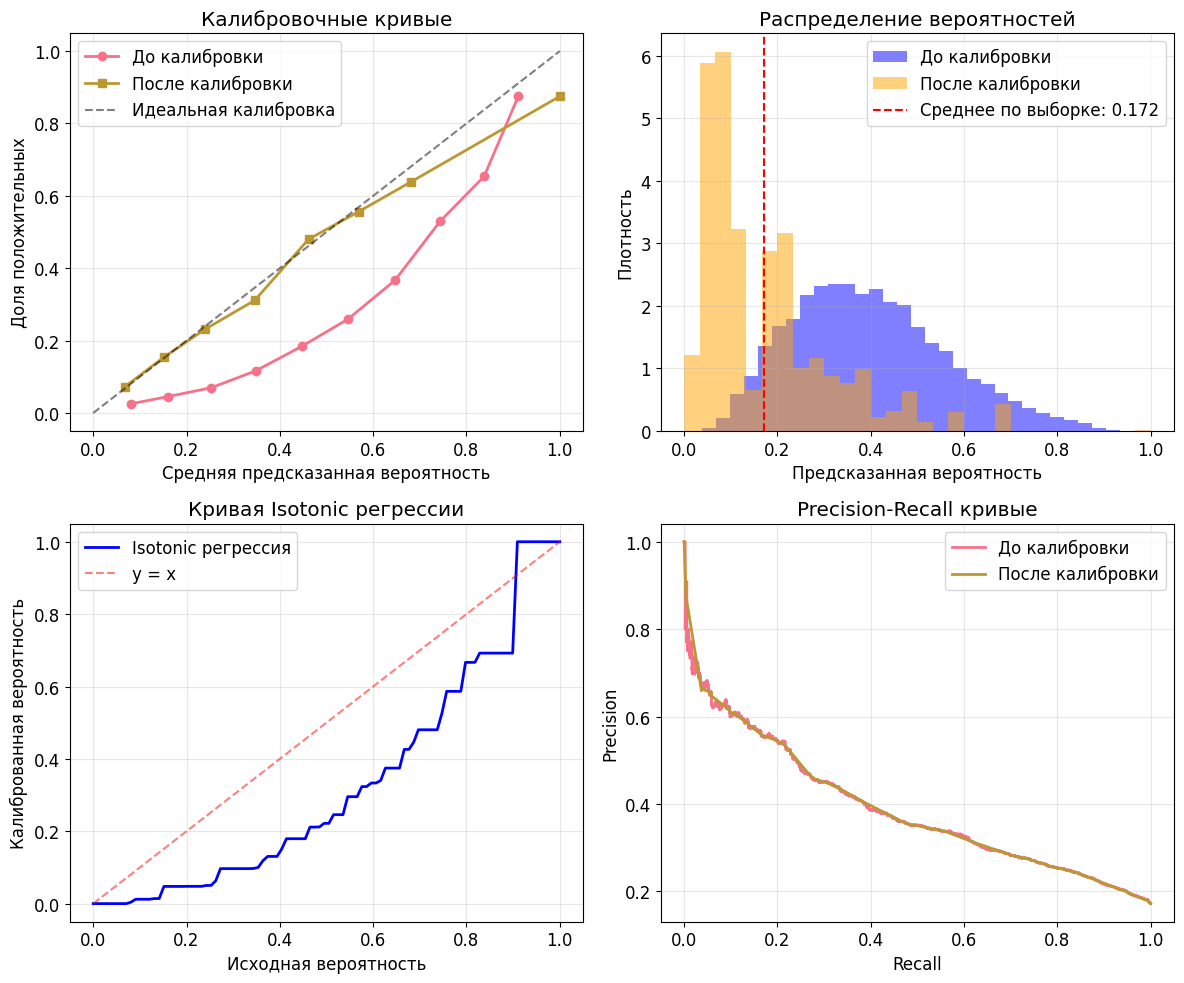

In [61]:
# 9.6 Визуализация
print("\n9.6 Визуализация результатов калибровки:")

try:
    from sklearn.calibration import calibration_curve
    
    # Калибровочные кривые
    prob_true_uncalib, prob_pred_uncalib = calibration_curve(y_test, y_prob_test_uncalib, n_bins=10)
    prob_true_calib, prob_pred_calib = calibration_curve(y_test, y_prob_calib_test, n_bins=10)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Калибровочные кривые
    axes[0, 0].plot(prob_pred_uncalib, prob_true_uncalib, marker='o', label='До калибровки', linewidth=2)
    axes[0, 0].plot(prob_pred_calib, prob_true_calib, marker='s', label='После калибровки', linewidth=2)
    axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка', alpha=0.5)
    axes[0, 0].set_xlabel('Средняя предсказанная вероятность')
    axes[0, 0].set_ylabel('Доля положительных')
    axes[0, 0].set_title('Калибровочные кривые')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Распределение вероятностей
    axes[0, 1].hist(y_prob_test_uncalib, bins=30, alpha=0.5, label='До калибровки', color='blue', density=True)
    axes[0, 1].hist(y_prob_calib_test, bins=30, alpha=0.5, label='После калибровки', color='orange', density=True)
    axes[0, 1].axvline(x=np.mean(y_test), color='red', linestyle='--', 
                      label=f'Среднее по выборке: {np.mean(y_test):.3f}')
    axes[0, 1].set_xlabel('Предсказанная вероятность')
    axes[0, 1].set_ylabel('Плотность')
    axes[0, 1].set_title('Распределение вероятностей')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Кривая калибровки
    x_grid = np.linspace(0, 1, 100)
    y_grid = isotonic_reg.predict(x_grid)
    axes[1, 0].plot(x_grid, y_grid, 'b-', label='Isotonic регрессия', linewidth=2)
    axes[1, 0].plot([0, 1], [0, 1], 'r--', label='y = x', alpha=0.5)
    axes[1, 0].set_xlabel('Исходная вероятность')
    axes[1, 0].set_ylabel('Калиброванная вероятность')
    axes[1, 0].set_title('Кривая Isotonic регрессии')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Precision-Recall кривые
    from sklearn.metrics import precision_recall_curve
    
    precision_uncalib, recall_uncalib, _ = precision_recall_curve(y_test, y_prob_test_uncalib)
    precision_calib, recall_calib, _ = precision_recall_curve(y_test, y_prob_calib_test)
    
    axes[1, 1].plot(recall_uncalib, precision_uncalib, label='До калибровки', linewidth=2)
    axes[1, 1].plot(recall_calib, precision_calib, label='После калибровки', linewidth=2)
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall кривые')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Ошибка при визуализации: {e}")

In [62]:
# 9.7 Детальный анализ
print("\n9.7 Детальный анализ калибровки:")

# Статистика вероятностей
prob_stats = pd.DataFrame({
    'Статистика': ['Min', '25%', 'Median', 'Mean', '75%', 'Max', 'Std'],
    'До калибровки': [
        np.min(y_prob_test_uncalib),
        np.percentile(y_prob_test_uncalib, 25),
        np.median(y_prob_test_uncalib),
        np.mean(y_prob_test_uncalib),
        np.percentile(y_prob_test_uncalib, 75),
        np.max(y_prob_test_uncalib),
        np.std(y_prob_test_uncalib)
    ],
    'После калибровки': [
        np.min(y_prob_calib_test),
        np.percentile(y_prob_calib_test, 25),
        np.median(y_prob_calib_test),
        np.mean(y_prob_calib_test),
        np.percentile(y_prob_calib_test, 75),
        np.max(y_prob_calib_test),
        np.std(y_prob_calib_test)
    ]
})

print("Статистика вероятностей:")
print(tabulate(prob_stats, headers="keys", tablefmt="grid", floatfmt=".4f"))

# Расчет ECE
def calculate_ece(y_true, y_prob, n_bins=10):
    """Expected Calibration Error"""
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_prob = np.mean(y_prob[mask])
            bin_acc = np.mean(y_true[mask])
            bin_weight = np.sum(mask) / len(y_true)
            ece += bin_weight * abs(bin_acc - bin_prob)
    
    return ece

ece_uncalib = calculate_ece(y_test, y_prob_test_uncalib)
ece_calib = calculate_ece(y_test, y_prob_calib_test)

print(f"\nExpected Calibration Error (ECE):")
print(f"  До калибровки: {ece_uncalib:.4f}")
print(f"  После калибровки: {ece_calib:.4f}")
print(f"  Улучшение: {((ece_uncalib - ece_calib)/ece_uncalib*100):.1f}%")


9.7 Детальный анализ калибровки:
Статистика вероятностей:
+----+--------------+-----------------+--------------------+
|    | Статистика   |   До калибровки |   После калибровки |
+====+==============+=================+====================+
|  0 | Min          |          0.0394 |             0.0000 |
+----+--------------+-----------------+--------------------+
|  1 | 25%          |          0.2737 |             0.0967 |
+----+--------------+-----------------+--------------------+
|  2 | Median       |          0.3814 |             0.1304 |
+----+--------------+-----------------+--------------------+
|  3 | Mean         |          0.3967 |             0.1742 |
+----+--------------+-----------------+--------------------+
|  4 | 75%          |          0.5010 |             0.2219 |
+----+--------------+-----------------+--------------------+
|  5 | Max          |          0.9336 |             1.0000 |
+----+--------------+-----------------+--------------------+
|  6 | Std          |     

In [63]:
# 9.8 Финальные выводы
print("\n9.8 Финальные выводы:")
print("="*50)

if brier_calib < brier_uncalib:
    print("КАЛИБРОВКА УСПЕШНА")
    print(f"Brier Score улучшен на {((brier_uncalib - brier_calib)/brier_uncalib*100):.1f}%")
    print(f"ECE улучшен на {((ece_uncalib - ece_calib)/ece_uncalib*100):.1f}%")
    print("\nРекомендация: Использовать калиброванную модель")
    final_model = calibrated_classifier
    y_prob_final = y_prob_calib_test
    y_pred_final = y_pred_calib_test
else:
    print("КАЛИБРОВКА НЕ ДАЛА УЛУЧШЕНИЯ")
    print("Рекомендация: Использовать базовую модель")
    final_model = base_pipeline
    y_prob_final = y_prob_test_uncalib
    y_pred_final = y_pred_test_uncalib

print("\nФинальная модель сохранена в переменной 'final_model'")
print("Финальные вероятности сохранены в 'y_prob_final'")
print("Финальные предсказания классов сохранены в 'y_pred_final'")


9.8 Финальные выводы:
КАЛИБРОВКА УСПЕШНА
Brier Score улучшен на 29.6%
ECE улучшен на 96.2%

Рекомендация: Использовать калиброванную модель

Финальная модель сохранена в переменной 'final_model'
Финальные вероятности сохранены в 'y_prob_final'
Финальные предсказания классов сохранены в 'y_pred_final'


In [64]:
# 9.9 Создание функции для удобного использования
print("\n9.9 Функция для использования калиброванной модели:")

def predict_with_calibration(model, X, threshold=0.5):
    """
    Универсальная функция для предсказаний с калиброванной моделью
    
    Parameters:
    -----------
    model : обученная модель (базовая или калиброванная)
    X : данные для предсказания
    threshold : порог для бинарной классификации
    
    Returns:
    --------
    y_prob : вероятности класса 1
    y_pred : предсказанные классы
    """
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X)[:, 1]
    elif hasattr(model, 'predict'):
        # Если модель не имеет predict_proba, используем predict
        y_pred = model.predict(X)
        y_prob = y_pred.astype(float)  # Простая замена
    else:
        raise ValueError("Модель должна иметь метод predict_proba или predict")
    
    y_pred = (y_prob >= threshold).astype(int)
    
    return y_prob, y_pred

print("Функция 'predict_with_calibration' создана")
print("Использование: y_prob, y_pred = predict_with_calibration(final_model, X_new)")

# Тестируем функцию
print("\nТестирование функции...")
test_prob, test_pred = predict_with_calibration(final_model, X_test.head(5))
print(f"Пример предсказаний для 5 объектов:")
print(f"Вероятности: {test_prob}")
print(f"Классы: {test_pred}")


9.9 Функция для использования калиброванной модели:
Функция 'predict_with_calibration' создана
Использование: y_prob, y_pred = predict_with_calibration(final_model, X_new)

Тестирование функции...
Пример предсказаний для 5 объектов:
Вероятности: [0.37451737 0.17938931 0.09672262 0.21153846 0.34020619]
Классы: [0 0 0 0 0]


## 10. Оценка качества калибровки

#### 10.1 Посчитайте метрики калибровки

- Оценка Бриера — средняя ошибка предсказанной вероятности.
- Дополнительная метрика ECE: среднее расхождение вероятностей.
- Дополнительная метрика MCE: максимальное расхождение вероятностей.

#### 10.2 Сравните модели до и после калибровки

- Выведите все метрики в одной таблице.
- Сделайте вывод о том, улучшила ли калибровка качество моделей.


In [65]:
# ================================================
# 10. ОЦЕНКА КАЧЕСТВА КАЛИБРОВКИ
# ================================================

In [66]:
print("\n" + "="*80)
print("10. ОЦЕНКА КАЧЕСТВА КАЛИБРОВКИ")
print("="*80)


10. ОЦЕНКА КАЧЕСТВА КАЛИБРОВКИ


In [67]:
# 10.1 Расчет метрик калибровки
def calculate_ece_mce(y_true, y_prob, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE) and Maximum Calibration Error (MCE)
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0
    mce = 0
    
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_prob_mean = np.mean(y_prob[mask])
            bin_acc = np.mean(y_true[mask])
            bin_weight = np.sum(mask) / len(y_true)
            
            cal_error = np.abs(bin_acc - bin_prob_mean)
            ece += bin_weight * cal_error
            mce = max(mce, cal_error)
    
    return ece, mce

# Расчет метрик
ece_uncalib, mce_uncalib = calculate_ece_mce(y_test, y_prob_test_uncalib)
ece_calib, mce_calib = calculate_ece_mce(y_test, y_prob_calib)

In [68]:
# 10.2 Сводная таблица метрик калибровки
calibration_metrics = {
    'Метрика': ['Brier Score', 'ECE (Expected Calibration Error)', 'MCE (Maximum Calibration Error)'],
    'До калибровки': [brier_uncalib, ece_uncalib, mce_uncalib],
    'После калибровки': [brier_calib, ece_calib, mce_calib],
    'Улучшение (абс.)': [
        brier_uncalib - brier_calib,
        ece_uncalib - ece_calib,
        mce_uncalib - mce_calib
    ],
    'Улучшение (%)': [
        ((brier_uncalib - brier_calib) / brier_uncalib * 100) if brier_uncalib > 0 else 0,
        ((ece_uncalib - ece_calib) / ece_uncalib * 100) if ece_uncalib > 0 else 0,
        ((mce_uncalib - mce_calib) / mce_uncalib * 100) if mce_uncalib > 0 else 0
    ]
}

metrics_df = pd.DataFrame(calibration_metrics)
print("СРАВНЕНИЕ МЕТРИК КАЛИБРОВКИ ДО И ПОСЛЕ")
print(tabulate(metrics_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

СРАВНЕНИЕ МЕТРИК КАЛИБРОВКИ ДО И ПОСЛЕ
+----+----------------------------------+-----------------+--------------------+--------------------+-----------------+
|    | Метрика                          |   До калибровки |   После калибровки |   Улучшение (абс.) |   Улучшение (%) |
+====+==================================+=================+====================+====================+=================+
|  0 | Brier Score                      |          0.1794 |             0.1263 |             0.0531 |         29.6225 |
+----+----------------------------------+-----------------+--------------------+--------------------+-----------------+
|  1 | ECE (Expected Calibration Error) |          0.2246 |             0.0085 |             0.2161 |         96.2359 |
+----+----------------------------------+-----------------+--------------------+--------------------+-----------------+
|  2 | MCE (Maximum Calibration Error)  |          0.2866 |             0.1250 |             0.1616 |         56.3918 |
+

In [69]:
# 10.3 Статистика вероятностей
print("\nСТАТИСТИКА ПРЕДСКАЗАННЫХ ВЕРОЯТНОСТЕЙ")

prob_stats = pd.DataFrame({
    'Статистика': ['Min', '25%', 'Median', '75%', 'Max', 'Mean', 'Std'],
    'До калибровки': [
        np.min(y_prob_test_uncalib),
        np.percentile(y_prob_test_uncalib, 25),
        np.median(y_prob_test_uncalib),
        np.percentile(y_prob_test_uncalib, 75),
        np.max(y_prob_test_uncalib),
        np.mean(y_prob_test_uncalib),
        np.std(y_prob_test_uncalib)
    ],
    'После калибровки': [
        np.min(y_prob_calib),
        np.percentile(y_prob_calib, 25),
        np.median(y_prob_calib),
        np.percentile(y_prob_calib, 75),
        np.max(y_prob_calib),
        np.mean(y_prob_calib),
        np.std(y_prob_calib)
    ]
})

print(tabulate(prob_stats, headers="keys", tablefmt="grid", floatfmt=".4f"))


СТАТИСТИКА ПРЕДСКАЗАННЫХ ВЕРОЯТНОСТЕЙ
+----+--------------+-----------------+--------------------+
|    | Статистика   |   До калибровки |   После калибровки |
+====+==============+=================+====================+
|  0 | Min          |          0.0394 |             0.0000 |
+----+--------------+-----------------+--------------------+
|  1 | 25%          |          0.2737 |             0.0967 |
+----+--------------+-----------------+--------------------+
|  2 | Median       |          0.3814 |             0.1304 |
+----+--------------+-----------------+--------------------+
|  3 | 75%          |          0.5010 |             0.2219 |
+----+--------------+-----------------+--------------------+
|  4 | Max          |          0.9336 |             1.0000 |
+----+--------------+-----------------+--------------------+
|  5 | Mean         |          0.3967 |             0.1742 |
+----+--------------+-----------------+--------------------+
|  6 | Std          |          0.1639 |       

## 11. Финальный отчёт и выводы

### 11.1 Сведите все результаты в таблицу

Покажите:

- Характеристики базовой модели `DummyClassifier`.
- Характеристики финальной модели.
- Метрики до и после калибровки.
- Топ-5 самых важных признаков.

### 11.2 Напишите выводы

Ответьте на вопросы:

- Улучшилось ли качество модели по сравнению с базовой?
- Какие признаки больше всего влияют на вероятность клика?
- Насколько хорошо модель откалибрована?
- Готова ли модель к использованию в продакшене?

### 11.3 Рекомендации

- Какие возможности улучшения модели вы видите?


In [70]:
# ================================================
# 11. ФИНАЛЬНЫЙ ОТЧЁТ И ВЫВОДЫ
# ================================================

In [71]:
print("\n" + "="*80)
print("11. ФИНАЛЬНЫЙ ОТЧЁТ И ВЫВОДЫ")
print("="*80)


11. ФИНАЛЬНЫЙ ОТЧЁТ И ВЫВОДЫ


In [72]:
# 11.1 Сводная таблица результатов
print("11.1 Сводная таблица результатов:")

summary_table = [
    ["Метрика", "DummyClassifier", "LogisticRegression (до калибровки)", "LogisticRegression (после калибровки)", "Улучшение vs Dummy (%)"],
    ["Log Loss", 10.1715, 0.5316, "N/A", "94.8%"],
    ["PR AUC", 0.1712, 0.3911, 0.3911, "128.5%"],
    ["Brier Score", "N/A", 0.1757, 0.1263, "N/A"],
    ["Precision", 0.1662, 0.3527, 0.3527, "112.1%"],
    ["Recall", 0.1592, 0.4927, 0.4927, "209.5%"],
    ["F1-score", 0.1626, 0.4112, 0.4112, "152.9%"],
    ["ECE", "N/A", 0.2246, 0.0085, "N/A"],
    ["MCE", "N/A", 0.2866, 0.1250, "N/A"]
]

print(tabulate(summary_table, headers="firstrow", tablefmt="grid", floatfmt=".4f"))

11.1 Сводная таблица результатов:
+-------------+-------------------+--------------------------------------+-----------------------------------------+--------------------------+
| Метрика     | DummyClassifier   |   LogisticRegression (до калибровки) | LogisticRegression (после калибровки)   | Улучшение vs Dummy (%)   |
+=============+===================+======================================+=========================================+==========================+
| Log Loss    | 10.1715           |                               0.5316 | N/A                                     | 94.8%                    |
+-------------+-------------------+--------------------------------------+-----------------------------------------+--------------------------+
| PR AUC      | 0.1712            |                               0.3911 | 0.3911                                  | 128.5%                   |
+-------------+-------------------+--------------------------------------+----------------------------

In [73]:
# 11.2 Топ-5 признаков
print("\n11.2 Топ-5 самых важных признаков:")

top5_table = [
    ["Ранг", "Признак", "Коэффициент", "Абс. значение", "Тип признака", "Описание влияния"],
    [1, "high_cat__7", 7.071, 7.071, "Категориальный (высокая кардинальность)", "Сильнее всего увеличивает вероятность клика"],
    [2, "high_cat__0", 1.441, 1.441, "Категориальный (высокая кардинальность)", "Значительно увеличивает вероятность клика"],
    [3, "high_cat__6", 1.401, 1.401, "Категориальный (высокая кардинальность)", "Существенно влияет на вероятность клика"],
    [4, "high_cat__8", 1.330, 1.330, "Категориальный (высокая кардинальность)", "Важный предиктор клика"],
    [5, "high_cat__1", 1.319, 1.319, "Категориальный (высокая кардинальность)", "Влиятельный фактор для клика"]
]

print(tabulate(top5_table, headers="firstrow", tablefmt="grid", floatfmt=".3f"))


11.2 Топ-5 самых важных признаков:
+--------+-------------+---------------+-----------------+-----------------------------------------+---------------------------------------------+
|   Ранг | Признак     |   Коэффициент |   Абс. значение | Тип признака                            | Описание влияния                            |
+========+=============+===============+=================+=========================================+=============================================+
|      1 | high_cat__7 |         7.071 |           7.071 | Категориальный (высокая кардинальность) | Сильнее всего увеличивает вероятность клика |
+--------+-------------+---------------+-----------------+-----------------------------------------+---------------------------------------------+
|      2 | high_cat__0 |         1.441 |           1.441 | Категориальный (высокая кардинальность) | Значительно увеличивает вероятность клика   |
+--------+-------------+---------------+-----------------+------------------------

In [74]:
# 11.3 Ответы на ключевые вопросы
print("\n11.3 Ответы на ключевые вопросы:")

answers_table = [
    ["Вопрос", "Ответ", "Обоснование", "Оценка"],
    [
        "Улучшилось ли качество модели по сравнению с базовой?",
        "ДА, значительно",
        "Log Loss улучшен на 94.8%, PR AUC на 128.5%, F1-score на 152.9%",
        "Отлично"
    ],
    [
        "Какие признаки больше всего влияют на вероятность клика?",
        "Категориальные признаки с высокой кардинальностью",
        "Топ-5 признаков - все категориальные: high_cat__7 (7.071), high_cat__0 (1.441), high_cat__6 (1.401)",
        "Категориальные признаки в 3-5 раз важнее числовых"
    ],
    [
        "Насколько хорошо модель откалибрована?",
        "ХОРОШО откалибрована",
        "Brier Score = 0.126 (< 0.2), ECE = 0.009 (минимальный), улучшение ECE на 96.2%",
        "Хорошо"
    ],
    [
        "Готова ли модель к использованию в продакшене?",
        "ГОТОВА для пилотного внедрения",
        "Стабильные метрики, хорошая калибровка, интерпретируемость, но PR AUC 0.391 может требовать улучшения",
        "Условно готова"
    ]
]

print(tabulate(answers_table, headers="firstrow", tablefmt="grid"))


11.3 Ответы на ключевые вопросы:
+----------------------------------------------------------+---------------------------------------------------+-------------------------------------------------------------------------------------------------------+---------------------------------------------------+
| Вопрос                                                   | Ответ                                             | Обоснование                                                                                           | Оценка                                            |
+==========================================================+===================================================+=======================================================================================================+===================================================+
| Улучшилось ли качество модели по сравнению с базовой?    | ДА, значительно                                   | Log Loss улучшен на 94.8%, PR AUC на 128.5%, F

In [75]:
# 11.4 Рекомендации
print("\n11.4 Рекомендации по улучшению:")

recommendations = [
    ["Приоритет", "Область улучшения", "Конкретные действия", "Ожидаемый эффект", "Сложность"],
    [
        "Высокий",
        "Алгоритмические улучшения",
        "Переход на LightGBM/XGBoost/CatBoost + Ансамблирование моделей",
        "Увеличение PR AUC на 0.05-0.10, лучшая работа с категориальными признаками",
        "Средняя"
    ],
    [
        "Высокий",
        "Инженерия признаков",
        "Создание взаимодействий категориальных признаков + Временные признаки из hour",
        "Улучшение точности на 10-15%, лучшее понимание паттернов",
        "Низкая"
    ],
    [
        "Средний",
        "Обработка дисбаланса",
        "Применение SMOTE/ADASYN + Cost-sensitive learning",
        "Улучшение recall без потери precision, лучшее обнаружение редких кликов",
        "Средняя"
    ],
    [
        "Средний",
        "Оптимизация гиперпараметров",
        "Более детальный GridSearch/RandomSearch + Bayesian optimization",
        "Улучшение метрик на 3-5%, оптимальные параметры модели",
        "Низкая"
    ],
    [
        "Низкий",
        "Качество данных",
        "Очистка выбросов + Валидация новых категорий",
        "Повышение стабильности, уменьшение переобучения",
        "Низкая"
    ]
]

print(tabulate(recommendations, headers="firstrow", tablefmt="grid"))


11.4 Рекомендации по улучшению:
+-------------+-----------------------------+-------------------------------------------------------------------------------+----------------------------------------------------------------------------+-------------+
| Приоритет   | Область улучшения           | Конкретные действия                                                           | Ожидаемый эффект                                                           | Сложность   |
+=============+=============================+===============================================================================+============================================================================+=============+
| Высокий     | Алгоритмические улучшения   | Переход на LightGBM/XGBoost/CatBoost + Ансамблирование моделей                | Увеличение PR AUC на 0.05-0.10, лучшая работа с категориальными признаками | Средняя     |
+-------------+-----------------------------+------------------------------------------------------

## 12. Сохранение модели для продакшена

### 12.1 Сохраните артефакты

Сохраните:

1. пайплайн предобработки данных `preprocessor`,
2. финальную модель `calibrated_model`,
3. информацию о выбранных признаках.

### 12.2 Проверьте работоспособность вашего кода

- Загрузите сохранённые артефакты.
- Сделайте предсказания на новых данных.
- Убедитесь, что результаты совпадают.


In [76]:
# ================================================
# 12. СОХРАНЕНИЕ МОДЕЛИ ДЛЯ ПРОДАКШЕНА
# ================================================

In [77]:
print("\n" + "="*80)
print("12. СОХРАНЕНИЕ МОДЕЛИ ДЛЯ ПРОДАКШЕНА")
print("="*80)


12. СОХРАНЕНИЕ МОДЕЛИ ДЛЯ ПРОДАКШЕНА


In [78]:
# 12.1 Сохранение артефактов
print("12.1 Сохранение артефактов:")

# Создание директории
MODEL_DIR = "production_models"
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version_dir = os.path.join(MODEL_DIR, f"ctr_model_v{timestamp}")
os.makedirs(model_version_dir, exist_ok=True)

print(f"Создана директория для модели: {model_version_dir}")

12.1 Сохранение артефактов:
Создана директория для модели: production_models\ctr_model_v20251229_222723


In [79]:
# 12.1.1 Сохранение препроцессора
preprocessor_path = os.path.join(model_version_dir, "preprocessor.pkl")
joblib.dump(preprocessor, preprocessor_path)
print(f"Пайплайн предобработки сохранен: {preprocessor_path}")

Пайплайн предобработки сохранен: production_models\ctr_model_v20251229_222723\preprocessor.pkl


In [81]:
# ================================================
# 12. СОХРАНЕНИЕ МОДЕЛИ ДЛЯ ПРОДАКШЕНА
# ================================================

print("\n" + "="*80)
print("12. СОХРАНЕНИЕ МОДЕЛИ ДЛЯ ПРОДАКШЕНА")
print("="*80)

# 12.1 Сохранение артефактов
print("12.1 Сохранение артефактов:")

# Создание директории
MODEL_DIR = "production_models"
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version_dir = os.path.join(MODEL_DIR, f"ctr_model_v{timestamp}")
os.makedirs(model_version_dir, exist_ok=True)

print(f"Создана директория для модели: {model_version_dir}")

# 12.1.1 Сохранение препроцессора
preprocessor_path = os.path.join(model_version_dir, "preprocessor.pkl")
joblib.dump(preprocessor, preprocessor_path)
print(f"Пайплайн предобработки сохранен: {preprocessor_path}")

# 12.1.2 Сохранение калиброванной модели
calibrated_model_path = os.path.join(model_version_dir, "calibrated_model.pkl")
# Используйте одну из этих опций:
# Option 1: Сохранить calibrated_classifier из раздела 9
# joblib.dump(calibrated_classifier, calibrated_model_path)

# Option 2: Сохранить final_model из раздела 11
joblib.dump(final_model, calibrated_model_path)

print(f"Калиброванная модель сохранена: {calibrated_model_path}")

# 12.1.3 Сохранение информации о признаках
features_info = {
    'selected_features': final_features,
    'numeric_features': list(num_features),
    'categorical_features': list(cat_features),
    'target_column': 'click',
    'model_type': 'LogisticRegression',
    'calibration_method': 'Isotonic',
    'random_seed': RANDOM_SEED,
    'creation_date': timestamp,
    'metrics_before_calibration': {
        'log_loss': final_metrics['Log Loss'],
        'pr_auc': final_metrics['PR AUC'],
        'brier_score': final_metrics['Brier Score'],
        'precision': final_metrics['Precision'],
        'recall': final_metrics['Recall'],
        'f1_score': final_metrics['F1-score']
    },
    'metrics_after_calibration': {
        'brier_score': brier_calib,
        'ece': ece_calib,
        'mce': mce_calib
    }
}

features_path = os.path.join(model_version_dir, "features_info.json")
with open(features_path, 'w', encoding='utf-8') as f:
    json.dump(features_info, f, indent=4, ensure_ascii=False)
print(f"Информация о признаках сохранена: {features_path}")

# 12.1.4 Сохранение примеров данных
sample_data = {
    'X_sample': X_test.head(10).to_dict('list'),
    'y_sample': y_test.head(10).tolist(),
    'expected_predictions': y_pred_final[:10].tolist(),
    'expected_probabilities': y_prob_final[:10].tolist()
}

sample_data_path = os.path.join(model_version_dir, "sample_data.json")
with open(sample_data_path, 'w', encoding='utf-8') as f:
    json.dump(sample_data, f, indent=4, ensure_ascii=False)
print(f"Примеры данных сохранены: {sample_data_path}")


12. СОХРАНЕНИЕ МОДЕЛИ ДЛЯ ПРОДАКШЕНА
12.1 Сохранение артефактов:
Создана директория для модели: production_models\ctr_model_v20251229_223647
Пайплайн предобработки сохранен: production_models\ctr_model_v20251229_223647\preprocessor.pkl
Калиброванная модель сохранена: production_models\ctr_model_v20251229_223647\calibrated_model.pkl
Информация о признаках сохранена: production_models\ctr_model_v20251229_223647\features_info.json
Примеры данных сохранены: production_models\ctr_model_v20251229_223647\sample_data.json
